In [1]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from matplotlib.colors import LogNorm
import pandas as pd
import numpy as np
import seaborn as sns
import torch
from datasets import Dataset
from transformers import AutoTokenizer, AutoModelForMaskedLM, default_data_collator
from tqdm import tqdm

In [2]:
fm.fontManager.addfont('../../figs/plus-jakarta-sans/static/PlusJakartaSans-Regular.ttf')

# Set the font as the default for all text elements
plt.rcParams['font.family'] = "Plus Jakarta Sans"
plt.rcParams['font.sans-serif'] = "Plus Jakarta Sans"

In [3]:
df = pd.read_csv('../../src/bio_if/data/plmbias/common_proteins_progen_esm_loglikelihood.csv')

In [4]:
df.head()

,Entry,Entry Name,primary_protein_name,all_protein_names,Gene Names,Organism,Length,genus_species,domain,kingdom,...,Description,sequence,progen2-medium_fp16_False_ll,progen2-base_fp16_False_ll,progen2-large_fp16_False_ll,progen2-xlarge_fp16_False_ll,progen2-BFD90_fp16_False_ll,ESM2_650M_pppl,ESM2_3B_pppl,ESM2_15B_pppl
0,O00541,PESC_HUMAN,Pescadillo homolog,Pescadillo homolog,PES1,Homo sapiens (Human),588,Homo sapiens,Eukaryota,Animalia,...,sp|O00541|PESC_HUMAN Pescadillo homolog OS=Hom...,MGGLEKKKYERGSATNYITRNKARKKLQLSLADFRRLCILKGIYPH...,-0.877656,-0.739062,-0.673376,-0.275376,-0.557462,-1.376413,-1.153031,-0.863481
1,O15229,KMO_HUMAN,Kynurenine 3-monooxygenase,Kynurenine 3-monooxygenase (EC 1.14.13.9) (Kyn...,KMO,Homo sapiens (Human),486,Homo sapiens,Eukaryota,Animalia,...,sp|O15229|KMO_HUMAN Kynurenine 3-monooxygenase...,MDSSVIQRKKVAVIGGGLVGSLQACFLAKRNFQIDVYEAREDTRVA...,-1.115627,-1.019284,-1.055469,-0.597102,-0.828649,-1.078029,-0.841189,-0.721648
2,O15371,EIF3D_HUMAN,Eukaryotic translation initiation factor 3 sub...,Eukaryotic translation initiation factor 3 sub...,EIF3D EIF3S7,Homo sapiens (Human),548,Homo sapiens,Eukaryota,Animalia,...,sp|O15371|EIF3D_HUMAN Eukaryotic translation i...,MAKFMTPVIQDNPSGWGPCAVPEQFRDMPYQPFSKGDRLGKVADWT...,-1.028079,-0.465545,-0.500757,-0.104518,-0.289271,-1.767279,-1.147200,-0.939404
3,O15372,EIF3H_HUMAN,Eukaryotic translation initiation factor 3 sub...,Eukaryotic translation initiation factor 3 sub...,EIF3H EIF3S3,Homo sapiens (Human),352,Homo sapiens,Eukaryota,Animalia,...,sp|O15372|EIF3H_HUMAN Eukaryotic translation i...,MASRKEGTGSTATSSSSTAGAAGKGKGKGGSGDSAVKQVQIDGLVV...,-1.272828,-1.144460,-0.878840,-0.297281,-0.522815,-1.453510,-1.361511,-1.337643
4,O43148,MCES_HUMAN,mRNA cap guanine-N7 methyltransferase,mRNA cap guanine-N7 methyltransferase (EC 2.1....,RNMT KIAA0398,Homo sapiens (Human),476,Homo sapiens,Eukaryota,Animalia,...,sp|O43148|MCES_HUMAN mRNA cap guanine-N7 methy...,MANSAKAEEYEKMSLEQAKASVNSETESSFNINENTTASGTGLSEK...,-1.465531,-1.197696,-1.246382,-0.836779,-1.065558,-1.062195,-0.843875,-0.803533


In [5]:
df.shape

(7545, 23)

In [7]:
MODEL_NAME = 'facebook/esm2_t33_650M_UR50D'
DEVICE = 'cuda:4'

In [8]:
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModelForMaskedLM.from_pretrained(MODEL_NAME, device_map=DEVICE)

In [9]:
# print all tokens of the tokenizer
CANONICAL_AAS = 'ACDEFGHIKLMNPQRSTVWY'
tokenized_canonical_aas = tokenizer(CANONICAL_AAS)['input_ids'][1:-1]
assert not any([tokenized_canonical_aas[i] in tokenizer.all_special_ids for i in range(len(tokenized_canonical_aas))])
assert len(tokenized_canonical_aas) == len(CANONICAL_AAS)
print(tokenizer)
print(tokenizer.special_tokens_map)
print(tokenized_canonical_aas)

EsmTokenizer(name_or_path='facebook/esm2_t33_650M_UR50D', vocab_size=33, model_max_length=1000000000000000019884624838656, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'eos_token': '<eos>', 'unk_token': '<unk>', 'pad_token': '<pad>', 'cls_token': '<cls>', 'mask_token': '<mask>'}, clean_up_tokenization_spaces=True),  added_tokens_decoder={
	0: AddedToken("<cls>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	1: AddedToken("<pad>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	2: AddedToken("<eos>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	3: AddedToken("<unk>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	32: AddedToken("<mask>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}
{'eos_token': '<eos>', 'unk_token': '<unk>', 'pad_token': '<pad>', 'cls_token': '<cls>', 'mask_token':

In [10]:
# calculate true PPLs for ESM 650M
df['ESM2_650M_pppl_true'] = np.exp(-df['ESM2_650M_pppl'])

In [11]:
# get log likelihood of first sequence
seq = df['sequence'][0]
def get_log_likelihood(seq):
    model.eval()
    seqs = [seq]
    for i in range(len(seq)):
        masked_seq = seq[:i] + '<mask>' + seq[i+1:]
        seqs.append(masked_seq)
    tokenized = tokenizer(seqs, padding='max_length', truncation=True, max_length=len(seq)+2, return_tensors='pt')
    assert torch.all(tokenized['input_ids'][:, -1] == tokenizer.eos_token_id)
    default_seq = {k: v[0:1] for k, v in tokenized.items()}
    tokenized = {k: v[1:] for k, v in tokenized.items()}

    BATCH_SIZE = 128
    total = 0
    dataset = Dataset.from_dict(tokenized)
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=BATCH_SIZE, collate_fn=default_data_collator)
    for i, batch in tqdm(enumerate(dataloader), total=len(dataloader)):
        bs = batch['input_ids'].shape[0]
        for k, v in batch.items():
            batch[k] = v.to(DEVICE)
        
        with (torch.no_grad(), torch.cuda.amp.autocast(enabled='cuda' in DEVICE)):
            outputs = model(**batch) # [batch_size, seq_len, num_tokens]
        individual_lls = torch.log_softmax(outputs.logits, dim=-1)[
            torch.arange(bs),
            torch.arange(1+i*BATCH_SIZE, 1+i*BATCH_SIZE+bs),
        ] # [batch_size, seq_len]
        total += sum(individual_lls[torch.arange(bs), default_seq['input_ids'][0, 1+i*BATCH_SIZE:1+i*BATCH_SIZE+bs]])
    return total.item() / len(seq) 

In [11]:
lls = []
for seq in tqdm(df['sequence'][:10]):
    lls.append(get_log_likelihood(seq))
    print(lls[-1])

 10%|█         | 1/10 [00:10<01:38, 10.94s/it]

-1.376540826291454


 20%|██        | 2/10 [00:17<01:04,  8.09s/it]

-1.0783214176633231


 30%|███       | 3/10 [00:25<00:57,  8.26s/it]

-1.7674027046147924


 40%|████      | 4/10 [00:28<00:37,  6.25s/it]

-1.45390831340443


 50%|█████     | 5/10 [00:34<00:31,  6.22s/it]

-1.0620464036444657


 60%|██████    | 6/10 [00:36<00:18,  4.55s/it]

-0.8018189786329801


 70%|███████   | 7/10 [01:08<00:41, 13.68s/it]

-0.7799362848801326


 80%|████████  | 8/10 [01:12<00:20, 10.44s/it]

-1.4322663994245632


 90%|█████████ | 9/10 [02:38<00:34, 34.20s/it]

-2.0510792896213035


100%|██████████| 10/10 [02:46<00:00, 16.61s/it]

-1.403676134474734


Text(0, 0.5, 'df log likelihood')

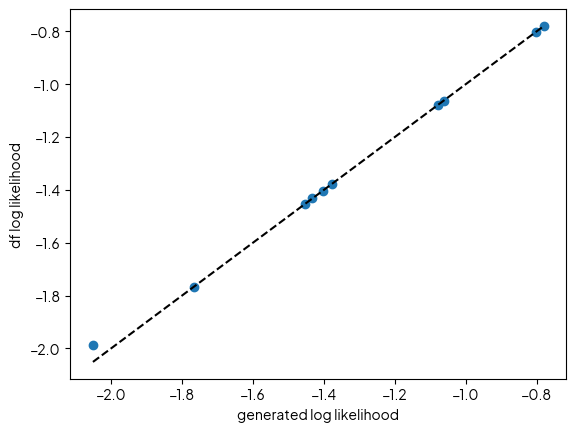

In [12]:
plt.plot(lls, df['ESM2_650M_pppl'][:len(lls)], 'o')
plt.plot([min(lls), max(lls)], [min(lls), max(lls)], 'k--')
plt.xlabel('generated log likelihood')
plt.ylabel('df log likelihood')

In [12]:
def get_one_shot_log_likelihood(model, tokenizer, device, seqs, eps=1e-4):
    model.eval()
    max_length = max([len(seq) for seq in seqs])
    tokenized = tokenizer(seqs, padding='max_length', truncation=True, max_length=max_length, return_tensors='pt')

    batch = {k: v.to(device) for k, v in tokenized.items()}
    label = batch['input_ids']
    label_special = torch.zeros_like(label, dtype=torch.bool)
    for special_id in tokenizer.all_special_ids:
        label_special |= label == special_id
    # label = label.masked_fill(label_special, -100)

    with (torch.no_grad(), torch.cuda.amp.autocast(enabled='cuda' in device)):
        # outputs = model(**batch).logits.transpose(1, 2) # [batch_size, num_tokens, seq_len]
        outputs = model(**batch).logits # [batch_size, seq_len, num_tokens]

    # individual_lls = torch.nn.functional.cross_entropy(outputs, label, reduction='none') # [batch_size, seq_len]
    # return -(individual_lls.sum(dim=-1) / (~label_special).sum(dim=-1)).numpy(force=True)
    individual_probs = torch.softmax(outputs, dim=-1).transpose(1, 2) # [batch_size, num_tokens, seq_len]
    individual_probs = individual_probs.gather(dim=1, index=label.unsqueeze(1)).squeeze(1) # [batch_size, seq_len]
    individual_probs = (individual_probs * 2 - 1).clamp(min=eps)
    log_probs = torch.log(individual_probs)
    log_probs = log_probs.masked_fill(label_special, 0)
    return (log_probs.sum(dim=-1) / (~label_special).sum(dim=-1)).numpy(force=True)

In [13]:
def get_one_shot_pppl(model, tokenizer, device, seqs, eps=1e-4):
    return np.exp(-get_one_shot_log_likelihood(model, tokenizer, device, seqs, eps))

In [14]:
seqs_sorted = list(zip(df['sequence'].tolist(), range(len(df['sequence']))))
print([x[1] for x in seqs_sorted[:5]])
seqs_sorted.sort(key=lambda x: -len(x[0]))
print([x[1] for x in seqs_sorted[:5]])

plls_sorted = []
batch_size = 16
for i in tqdm(range(0, len(df['sequence']), batch_size)):
    seqs = [s[0] for s in seqs_sorted[i:i+batch_size]]
    plls_sorted.append(get_one_shot_log_likelihood(model, tokenizer, DEVICE, seqs, eps=1e-5))
plls_sorted = np.concatenate(plls_sorted)

[0, 1, 2, 3, 4]
[1218, 1598, 180, 124, 1706]


100%|██████████| 472/472 [01:04<00:00,  7.28it/s]


In [15]:
plls = np.zeros_like(plls_sorted)
for i, j in enumerate(seqs_sorted):
    plls[j[1]] = plls_sorted[i]

In [16]:
df['esm650m_one_shot_ll'] = plls

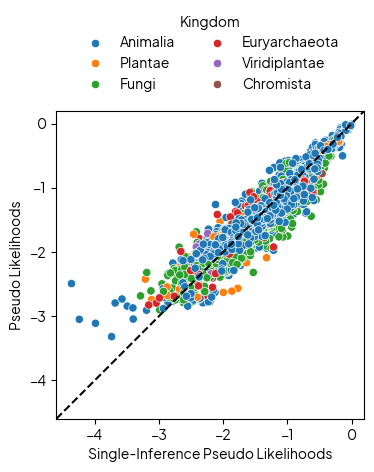

In [17]:
plt.figure(figsize=(4, 4))
sns.scatterplot(x='esm650m_one_shot_ll', y='ESM2_650M_pppl', data=df, hue='kingdom') # the dataframe says pppl but it's actually ppl
plt.xlabel('Single-Inference Pseudo Likelihoods')
plt.ylabel('Pseudo Likelihoods')
plt.axline((0.1, 0.1), slope=1, color='k', linestyle='--')
plt.gca().set_box_aspect(1)
plt.xlim(-4.6, 0.2)
plt.ylim(-4.6, 0.2)
# plt.xscale('symlog')
# plt.yscale('symlog')
plt.legend(title='Kingdom', bbox_to_anchor=(0.5, 1.35), loc='upper center', frameon=False, ncol=2)
plt.savefig('one_shot_pll_small.pdf', bbox_inches='tight')

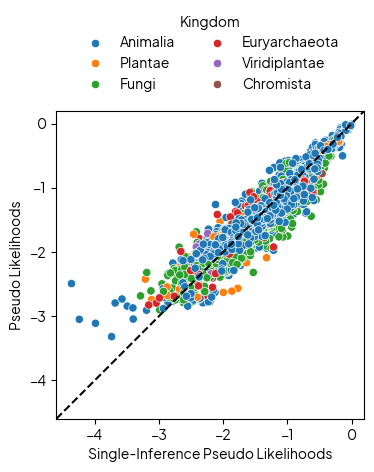

In [ ]:
plt.figure(figsize=(4, 4))
sns.scatterplot(x='esm650m_one_shot_ll', y='ESM2_650M_pppl', data=df, hue='kingdom') # the dataframe says pppl but it's actually ppl
plt.xlabel('Single-Inference Pseudo Likelihoods')
plt.ylabel('Pseudo Likelihoods')
plt.axline((0.1, 0.1), slope=1, color='k', linestyle='--')
plt.gca().set_box_aspect(1)
plt.xlim(-4.6, 0.2)
plt.ylim(-4.6, 0.2)
# plt.xscale('symlog')
# plt.yscale('symlog')
plt.legend(title='Kingdom', bbox_to_anchor=(0.5, 1.35), loc='upper center', frameon=False, ncol=2)
plt.savefig('one_shot_pll_small.pdf', bbox_inches='tight')

/tmp/ipykernel_3868838/511744813.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = df.groupby(pd.cut(df['esm650m_one_shot_ll'], bins=bins, duplicates='drop'))


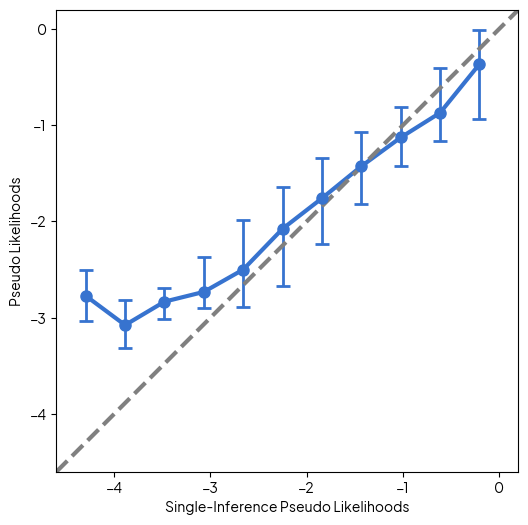

In [22]:
plt.figure(figsize=(6, 6))

# Define the bins with unique edges
# bins = [-4.5, -3.5, -2.5, -1.5, -0.5]
bins = np.linspace(-4.5, 0, 12)
xs = bins[:-1] + np.diff(bins) / 2

# Group the data, dropping duplicate bin edges
grouped = df.groupby(pd.cut(df['esm650m_one_shot_ll'], bins=bins, duplicates='drop'))

# Calculate mean and 95th percentile
means = grouped['ESM2_650M_pppl'].mean()
percentile_5 = grouped['ESM2_650M_pppl'].quantile(0.025)
percentile_95 = grouped['ESM2_650M_pppl'].quantile(0.975)

# Plot
plt.plot(xs, means, color='#3773CF', linewidth=3)
plt.errorbar(x=xs, y=means, 
             yerr=[means-percentile_5, percentile_95 - means],
             fmt='o', capsize=5, elinewidth=2, capthick=2, color='#3773CF', markersize=8)

plt.xlabel('Single-Inference Pseudo Likelihoods')
plt.ylabel('Pseudo Likelihoods')
plt.axline((0.1, 0.1), slope=1, color='gray', linestyle='--', linewidth=3)
plt.gca().set_box_aspect(1)
plt.xlim(-4.6, 0.2)
plt.ylim(-4.6, 0.2)

# plt.legend(title='Kingdom', bbox_to_anchor=(0.5, 1.35), loc='upper center', frameon=False, ncol=2)
plt.savefig('one_shot_pll_binned.pdf', bbox_inches='tight')

/tmp/ipykernel_3868838/228315530.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = df.groupby(pd.cut(df['esm650m_one_shot_ll'], bins=bins, duplicates='drop'))


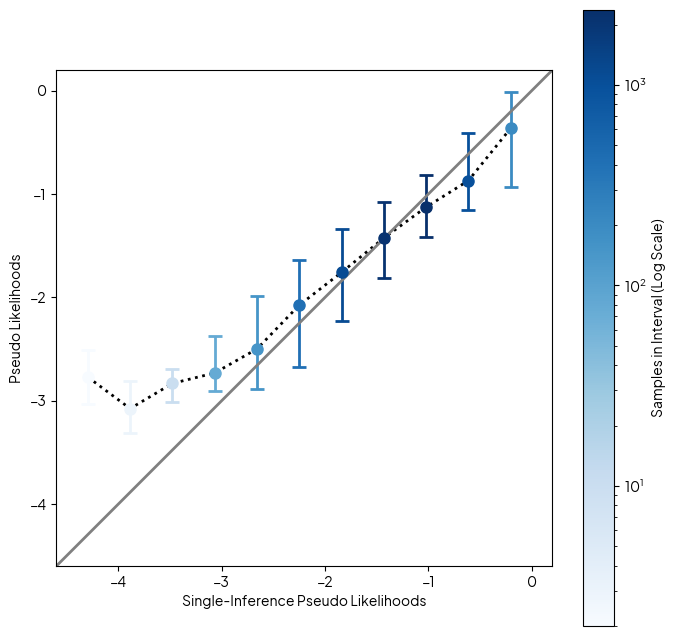

: 

In [33]:
fig, ax = plt.subplots(figsize=(8, 8))

# Define the bins with unique edges
bins = np.linspace(-4.5, 0, 12)
xs = bins[:-1] + np.diff(bins) / 2

# Group the data, dropping duplicate bin edges
grouped = df.groupby(pd.cut(df['esm650m_one_shot_ll'], bins=bins, duplicates='drop'))

# Calculate mean, 95th percentile, and count for each bin
means = grouped['ESM2_650M_pppl'].mean()
percentile_5 = grouped['ESM2_650M_pppl'].quantile(0.025)
percentile_95 = grouped['ESM2_650M_pppl'].quantile(0.975)
counts = grouped.size()

# Normalize counts for color mapping using log scale
norm = LogNorm(vmin=counts.min(), vmax=counts.max())
colors = plt.cm.Blues(norm(counts))

# Plot
ax.plot(xs, means, color='black', linestyle=':', linewidth=2)
for i, (x, y, yerr_low, yerr_high) in enumerate(zip(xs, means, means-percentile_5, percentile_95-means)):
    ax.errorbar(x, y, yerr=[[yerr_low], [yerr_high]], 
                fmt='o', capsize=5, elinewidth=2, capthick=2, 
                color=colors[i], markersize=8)

ax.set_xlabel('Single-Inference Pseudo Likelihoods')
ax.set_ylabel('Pseudo Likelihoods')
ax.axline((0.1, 0.1), slope=1, color='gray', linestyle='-', linewidth=2)
ax.set_box_aspect(1)
ax.set_xlim(-4.6, 0.2)
ax.set_ylim(-4.6, 0.2)

# Add colorbar with log scale
sm = plt.cm.ScalarMappable(cmap='Blues', norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax)
cbar.set_label('Samples in Interval (Log Scale)')

plt.savefig('one_shot_pll_binned.pdf', bbox_inches='tight')

In [31]:
# compute r squared for both pearson and spearman
from scipy.stats import pearsonr, spearmanr
sp = spearmanr(plls, df['ESM2_650M_pppl'])
pe = pearsonr(plls, df['ESM2_650M_pppl'])
print(f'spearman r: {sp}')
print(f'pearson r: {pe}')

spearman r: SignificanceResult(statistic=0.9227616715018876, pvalue=0.0)
pearson r: PearsonRResult(statistic=0.9301132880028856, pvalue=0.0)
